In [1]:
import numpy as np
import pandas as pd
import matplotlib as mlb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.graph_objects as go
import yfinance as yf
from arch import arch_model
import statsmodels.api as sm
import probscale

In [2]:
stock = yf.Ticker("SPY")
hist = stock.history(period='3y', interval='1d')
print(hist.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2018-07-03 to 2021-07-02
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          756 non-null    float64
 1   High          756 non-null    float64
 2   Low           756 non-null    float64
 3   Close         756 non-null    float64
 4   Volume        756 non-null    int64  
 5   Dividends     756 non-null    float64
 6   Stock Splits  756 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 47.2 KB
None


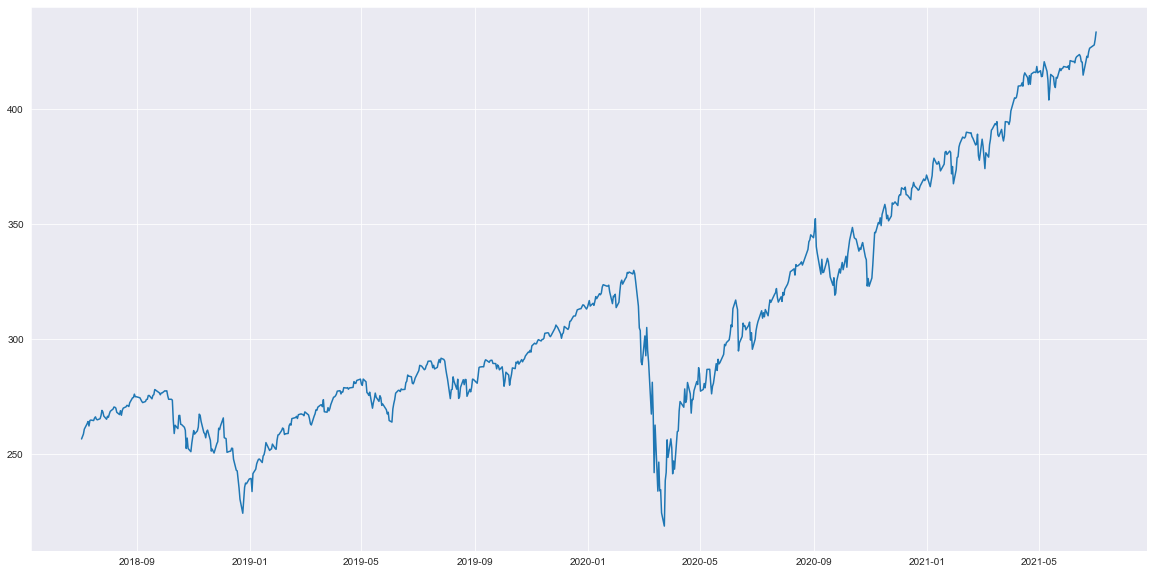

In [3]:
plt.figure(figsize=(20,10))
plt.plot(hist.Close)
plt.show()

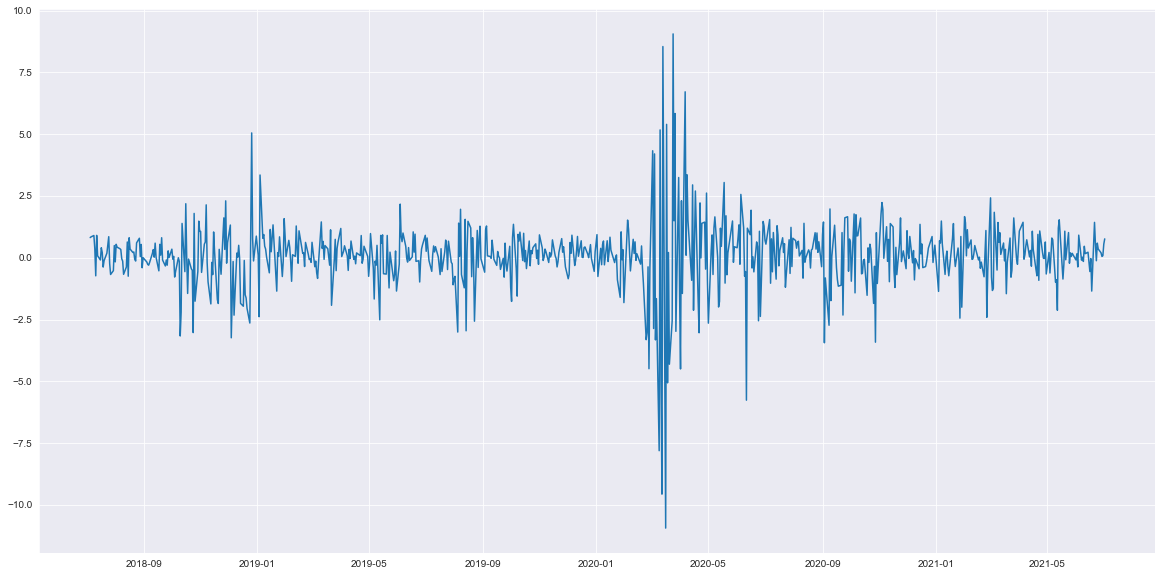

In [4]:
returns = 100 * hist.Close.pct_change().dropna()
plt.figure(figsize=(20,10))
plt.plot(returns)
plt.show()

(array([  2.,   1.,   2.,  16.,  69., 558.,  95.,   6.,   4.,   2.]),
 array([-10.94238383,  -8.94211331,  -6.94184279,  -4.94157226,
         -2.94130174,  -0.94103122,   1.0592393 ,   3.05950982,
          5.05978034,   7.06005086,   9.06032138]),
 <BarContainer object of 10 artists>)

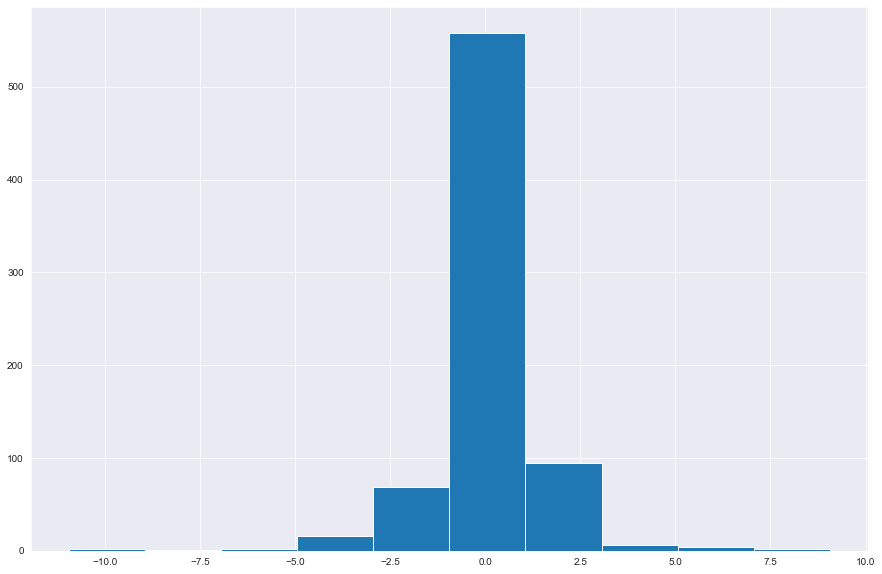

In [5]:
plt.figure(figsize=(15,10))
plt.hist(returns)

In [6]:
def autocorr_analysis(series, lags):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

    sm.graphics.tsa.plot_acf(series, ax=ax1, lags=lags)
    sm.graphics.tsa.plot_pacf(series, ax=ax2, lags=lags)

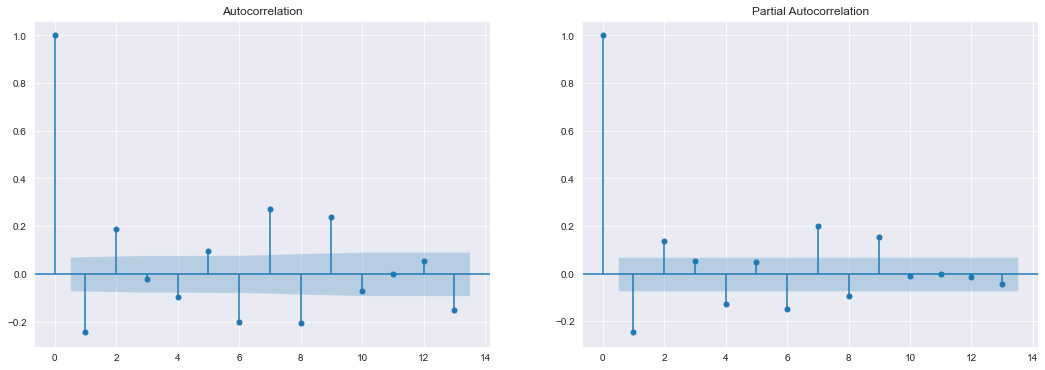

In [7]:
autocorr_analysis(returns, range(14))

In [8]:
distributions = ['normal', 'studentst', 'skewt', 'ged']
vol_models = ['GARCH', 'ARCH', 'EGARCH', 'HARCH']
means = ['constant', 'zero', 'LS', 'AR', 'ARX', 'HAR', 'HARX']
o_list = [0,1]
horizon = 30

model = None
best_bic = 10000000
for dist in distributions:
    for vol in vol_models:
        for mean in means:
            for o in o_list:
                m = arch_model(returns, vol=vol, p=1, o=o, q=1, dist=dist, mean=mean)
                r = m.fit(disp='off')
                if r.bic < best_bic:
                    best_bic = r.bic
                    model = m

results = model.fit(disp='off')
print(results.summary())

                             Zero Mean - EGARCH Model Results                            
Dep. Variable:                             Close   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.001
Vol Model:                                EGARCH   Log-Likelihood:               -996.587
Distribution:      Standardized Skew Student's t   AIC:                           2005.17
Method:                       Maximum Likelihood   BIC:                           2032.93
                                                   No. Observations:                  755
Date:                           Mon, Jul 05 2021   Df Residuals:                      755
Time:                                   15:08:50   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

In [9]:
def resid_analysis(residuals):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

    fig.suptitle('Residual Analysis', fontsize=18)
    ax1.hist(residuals)

    mlb.rc("figure", figsize=(4,4))
    sm.graphics.tsa.plot_acf(residuals, lags=range(1,30), ax=ax2)
    plt.show()

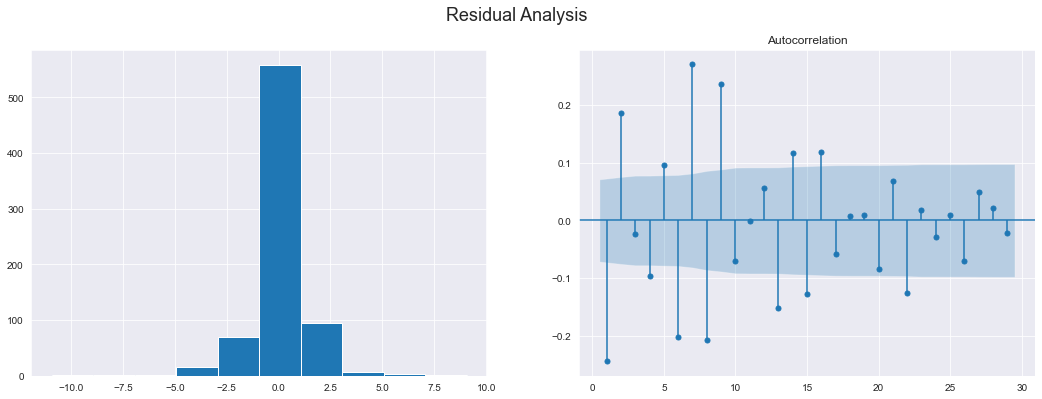

In [10]:
resid_analysis(results.resid)

In [11]:
sim_count = 5000
forecasts = results.forecast(horizon=horizon, method='simulation', simulations=sim_count, reindex=True)
sims = forecasts.simulations

C:\Users\alex\.conda\envs\ds\lib\site-packages\arch\univariate\volatility.py:2638: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


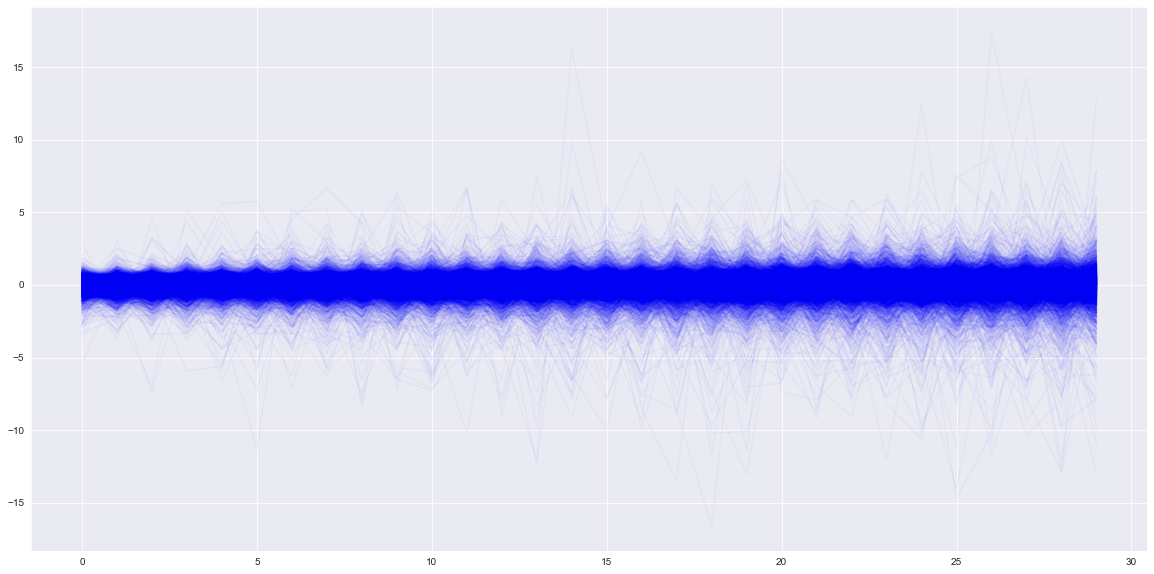

In [12]:
plt.figure(figsize=(20,10))
lines = plt.plot(sims.values[-1,:,:].T, color='blue', alpha=.03)
lines[0].set_label('Simulated paths')
plt.show()

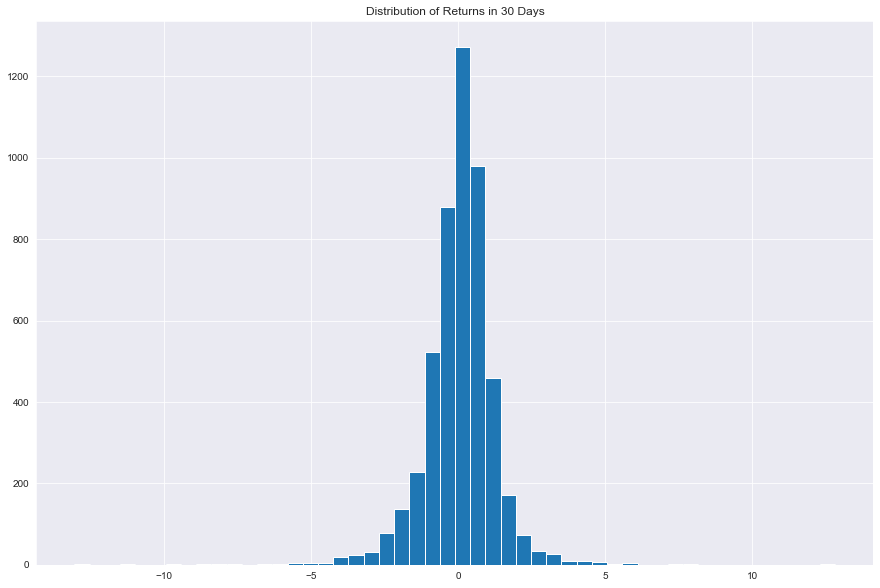

In [13]:
plt.figure(figsize=(15,10))
plt.hist(sims.values[-1, :,-1],bins=50)
plt.title(f'Distribution of Returns in {horizon} Days')
plt.show()

In [14]:
print(f'Volatility of forecasted returns: {sims.values[-1].std() * np.sqrt(252)}')

Volatility of forecasted returns: 15.160122898929268


In [15]:
sim_vals = sims.values[-1]
sim_vals = (sim_vals / 100) + 1

starting_price = np.full(shape=(sim_count,1), fill_value=hist.Close.iloc[-1])
sim_vals = np.column_stack((starting_price, sim_vals))
sim_vals = np.cumprod(sim_vals, axis=1)

end_vals = sim_vals[:, -1]

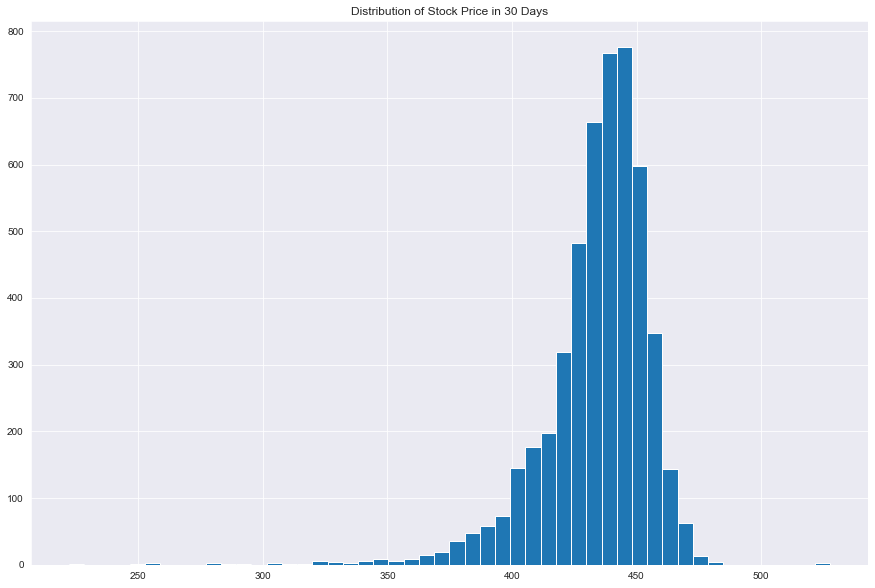

In [16]:
plt.figure(figsize=(15,10))
plt.hist(end_vals,bins=50)
plt.title(f'Distribution of Stock Price in {horizon} Days')
plt.show()

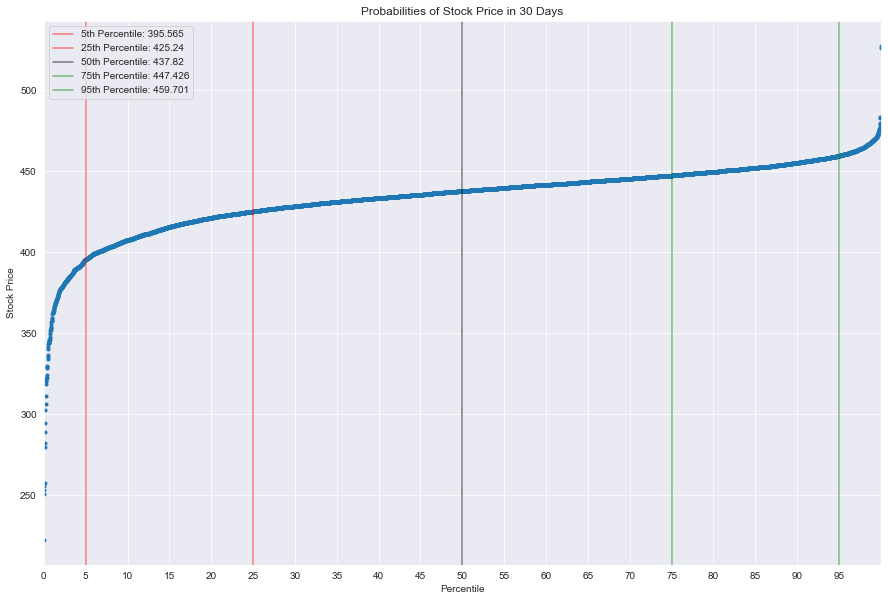

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
fig = probscale.probplot(end_vals, ax=ax, plottype='pp',
                         problabel='Percentile', datalabel='Stock Price',
                         scatter_kws=dict(marker='.', linestyle='none'))

plt.axvline(5, label=f'5th Percentile: {np.percentile(end_vals, 5).round(3)}', color='red', alpha=.5)
plt.axvline(25, label=f'25th Percentile: {np.percentile(end_vals, 25).round(3)}', color='red', alpha=.5)
plt.axvline(50, label=f'50th Percentile: {np.percentile(end_vals, 50).round(3)}', color='black', alpha=.5)
plt.axvline(75, label=f'75th Percentile: {np.percentile(end_vals, 75).round(3)}', color='green', alpha=.5)
plt.axvline(95, label=f'95th Percentile: {np.percentile(end_vals, 95).round(3)}', color='green', alpha=.5)
ax.set_xticks(range(0,100,5))
plt.legend(loc='upper left')
plt.title(f'Probabilities of Stock Price in {horizon} Days')
plt.show()